Tài liệu này mang giấy phép Creative Commons Attribution (CC BY).(c) Nguyễn Ngọc Sáng, Zhukovsky 12/2018.

[@SangVn](https://github.com/SangVn) [@VnCFD](https://vncfdgroup.wordpress.com/)

*Thực hành CFD với Python!*

<h1><center> Bài 9. Hệ phương trình Navier - Stokes cho chất lỏng không nén được. Phương pháp Projection </center></h1>

Phương pháp Projection đề xuất giải phương trình Navier-Stokes cho chất lỏng không nén được theo 3 bước:

* Bước 1. tìm nghiệm $\vec{v}^t$ tạm thời:

$$\frac{\vec{v}^t - \vec{v}^n}{\Delta t}+(\vec{v}^n\cdot\nabla)\vec{v}^n =\nu \nabla^2\vec{v}^n \qquad (9)$$ 

* Bước 2. tìm áp suất p tương ứng với vận tốc tạm thời:

$$\Delta p^{n+1} = \frac {\rho}{\Delta t}\nabla \vec{v}^t$$

* Bước 3. tìm nghiệm  $\vec{v}^{n+1}$:
$$\frac{\vec{v}^{n+1} - \vec{v}^n}{\Delta t} = -\frac{\nabla p^{n+1}}{\rho}$$

Ta sửa lại code ở bài 8 như sau:

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

#hạng tử thứ 2 phương trình poisson áp suất 
def f(res, u, v, dx, dy):
    res[1:-1, 1:-1] = 1./(2*dt)*((u[1:-1, 2:] - u[1:-1, 0:-2])/(2*dx) + (v[2:, 1:-1] - v[0:-2, 1:-1])/(2*dy))
    return res

#hàm tìm áp suất 
def poisson_p(p, res, dx, dy, rho):
    pn = np.empty_like(p)
    dx2 = dx**2
    dy2 = dy**2
    for n in range(ntp):
        pn = p.copy()
        p[1:-1, 1:-1] = ((pn[1:-1, 2:] + pn[1:-1, 0:-2])*dy2 +\
                        (pn[2:, 1:-1] + pn[0:-2, 1:-1])*dx2) / (2*(dx2 + dy2)) - \
                             rho*dx2*dy2/(dx2 + dy2)*res[1:-1, 1:-1]
        
        p[-1, :] = 0 #p = 0, y = 2
        p[0, :] = p[1, :] #dp/dy = 0, y = 0
        p[:, 0] = p[:, 1] #dp/dx = 0, x = 0
        p[:, -1] = p[:, -2] #dp/dx = 0, x = 2
  
    return p

#Hàm tìm nghiệm 
def solver(u, v, p, nt, dx, dy, rho, nu):
    #tạo các mảng chứa giá trị tạm thời 
    un = u.copy()
    vn = np.zeros_like(v)
    res = np.ones_like(p)
    u_tmp = u.copy()
    v_tmp = v.copy()
    
    #các hằng số
    dtbdx = dt/dx
    dtbdy = dt/dy
    nudtbdx2 = nu*dt/(dx**2)
    nudtbdy2 = nu*dt/(dy**2)
    dtbdx2r = dtbdx/(2*rho)
    dtbdy2r = dtbdy/(2*rho)
    
    #tíến theo thời gian 
    for n in range(nt):
        un = u.copy()
        vn = v.copy()  
        
        #Bước 1: tìm vận tốc tạm thời 
        u_tmp[1:-1, 1:-1] = un[1:-1, 1:-1] - un[1:-1, 1:-1]*dtbdx*(un[1:-1, 1:-1] - un[1:-1, 0:-2]) -\
                        vn[1:-1, 1:-1]*dtbdy*(un[1:-1, 1:-1] - un[0:-2, 1:-1]) + \
                        nudtbdx2*(un[1:-1, 2:] - 2*un[1:-1, 1:-1] + un[1:-1, 0:-2]) + \
                        nudtbdy2*(un[2:, 1:-1] - 2*un[1:-1, 1:-1] + un[0:-2, 1:-1])
        
        v_tmp[1:-1, 1:-1] = vn[1:-1, 1:-1] - un[1:-1, 1:-1]*dtbdx*(vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -\
                        vn[1:-1, 1:-1]*dtbdy*(vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) +\
                        nudtbdx2*(vn[1:-1, 2:] - 2*vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +\
                        nudtbdy2*(vn[2:, 1:-1] - 2*vn[1:-1, 1:-1] + vn[0:-2, 1:-1])
        
        #Bước 2: tìm áp suất 
        res = f(res, u_tmp, v_tmp, dx, dy)
        p = poisson_p(p, res, dx, dy, rho)
        
        #Bước 3: tìm vận tốc
        u[1:-1, 1:-1] = u_tmp[1:-1, 1:-1] - dtbdx2r*(p[1:-1, 2:] - p[1:-1, 0:-2]) 
        v[1:-1, 1:-1] = v_tmp[1:-1, 1:-1] - dtbdy2r*(p[2::, 1:-1] - p[0:-2, 1:-1])
        
        #điều kiện biên 
        u[0, :] = 0
        u[-1, :] = 1
        u[:, 0] = 0
        u[:, -1] = 0
        v[0, :] = 0
        v[-1, :] = 0
        v[:, 0] = 0
        v[:, -1] = 0
        
    return u, v, p

Với lưới đều $\Delta x = \Delta y = h$, điều kiện ổn định là:
$$\Delta t < \frac{4 \nu}{(|u|+|v|)^2} \ và \ \Delta t < \frac{h^2}{4\nu}$$

In [10]:
#thông số tính toán

#chia lưới 
nx = 51
ny = 51
x, dx = np.linspace(0, 1, nx, retstep=True)
y, dy = np.linspace(0, 1, ny, retstep=True)

#thông số dòng chảy 
rho = 1.
nu = 0.1

#điều kiện ổn định 
r = 0.8
dt = r*dx**2/(4*nu) 
ntp = 200

#Điều kiện ban đầu, điều kiện biên 
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))

u[-1, :] = 1

Để tạo file ảnh động hoặc video trước hết chúng ta cần tạo ra chuỗi 'sự kiện' - chuỗi ảnh, sau đó 'lắp ráp' chúng lại bằng phần mềm [ImageMagick](https://www.imagemagick.org) hay [ffmpeg](https://www.ffmpeg.org). Trước khi tiếp tục bạn phải cài hai phần mềm này vào máy.

In [11]:
#Khai báo figure 
fig = plt.figure(figsize=(11,7), dpi=100)
X, Y = np.meshgrid(x, y) #tạo lưới
plt.axis([0, 1, 0, 1])   #set trục 

#tạo thư mục img để chứa ảnh 
import os
if not os.path.exists('img'):
    os.mkdir('img')
    
#vẽ và lưu ảnh lại theo thứ tự thời gian     
for i in range(100):
    #nghiệm tìm dược ở bước i là đầu vào để tìm nghiệm sau 10 bước thời gian tại i+1
    u, v, p = solver(u, v, p, 10, dx, dy, rho, nu)
    plt.streamplot(X, Y, u, v)
    plt.title('time: %1.3f' % float(i*10*dt))
    plt.draw()
    plt.savefig('img/b8_%03d.png' % i)
    plt.clf()    

In [16]:
#tạo file gif
cmd = 'convert -delay 50 img/b8_*.png Bai_9.gif'
os.system(cmd)

#tạo file flv
cmd = 'ffmpeg -r 5 -i img/b8_%03d.png -vcodec flv Bai_9.flv'
os.system(cmd)

256

In [18]:
#xóa folder 'img'
import shutil
shutil.rmtree('img')

Ta thu được file ảnh động:
<img src='Bai_9.gif'>

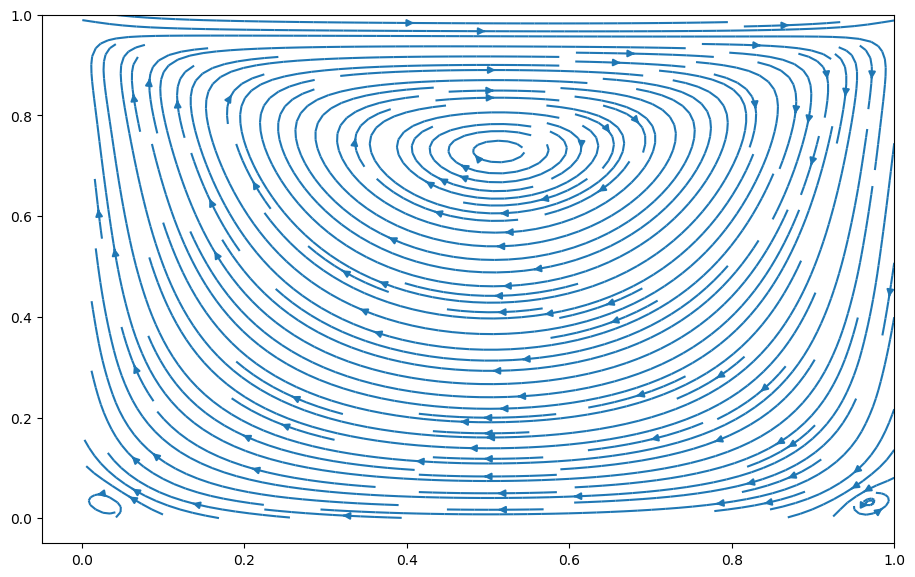

In [37]:
#tìm nghiệm ở bước thời gian nt = 2000, xét tính ổn định sơ đồ
u, v, p = solver_u(u, v, p, 2000, dx, dy, rho, nu)

#biểu diễn nghiệm 
fig = plt.figure(figsize=(11,7), dpi=100)
X, Y = np.meshgrid(x, y)
plt.streamplot(X, Y, u, v, density=2)  

plt.show()

Ở đây ta đã có thể thấy hai xoáy nhỏ ở góc. Để nhìn rõ hơn các bạn hãy thay đổi thông số 'density' trong hàm streamplot.

### [Bài 10. Hệ phương trình Navier - Stokes cho chất lỏng không nén được. Biến vector xoáy và hàm dòng ](Bai_10.ipynb)